In [1]:
'''
    Код для реализации обучения модели нейросети Artifact Removal Transformer для очистки ЭЭГ от артфектов
'''
import re 
import gc 
import os
import sys
import mne 
import glob
import math
import types
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
from tabulate import tabulate

import matplotlib.pyplot as plt
import torch.nn.functional as F

from collections import defaultdict
from torch.utils.data.dataset import random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from datasets import EEGArtifactDataset
from metrics import compute_snr, frequency_band_error_db, evaluate, print_metrics
from tf_model import (EncoderDecoder, Encoder, Decoder, Generator, EncoderLayer, DecoderLayer, MultiHeadedAttention, 
            PositionwiseFeedForward, ExpandConv, PositionalEncoding, make_model)



sol_files     = glob.glob("ICA/**/ica_solution.fif") # Объект MNE хранящий решение ICA разложения (матрица W)
iclabel_files = glob.glob("ICA/**/ICLabel_info.pkl") # файл хранящий информацию о raw файле поданного на ICA, ICA sources, 
                                                     # и классификацию компонент
print(len(sol_files), len(iclabel_files))
assert len(sol_files) == len(iclabel_files)

1647 1647


/home/aysurkov/.conda/envs/ml_cb/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Total subjects: 179
First participants: ['sub-NDARMR491LM5', 'sub-NDARBX400RTC', 'sub-NDARRD326KB9', 'sub-NDARCN669XPR', 'sub-NDARGB441VVD']
Train: 125 subjects, 1146 files
Valid: 27 subjects, 242 files
Test: 27 subjects, 259 files
Available CPU cores: 25


  0%|          | 0/1146 [00:00<?, ?it/s]

  0%|          | 0/1146 [00:00<?, ?it/s]

К анализу было допущено 325 файлов


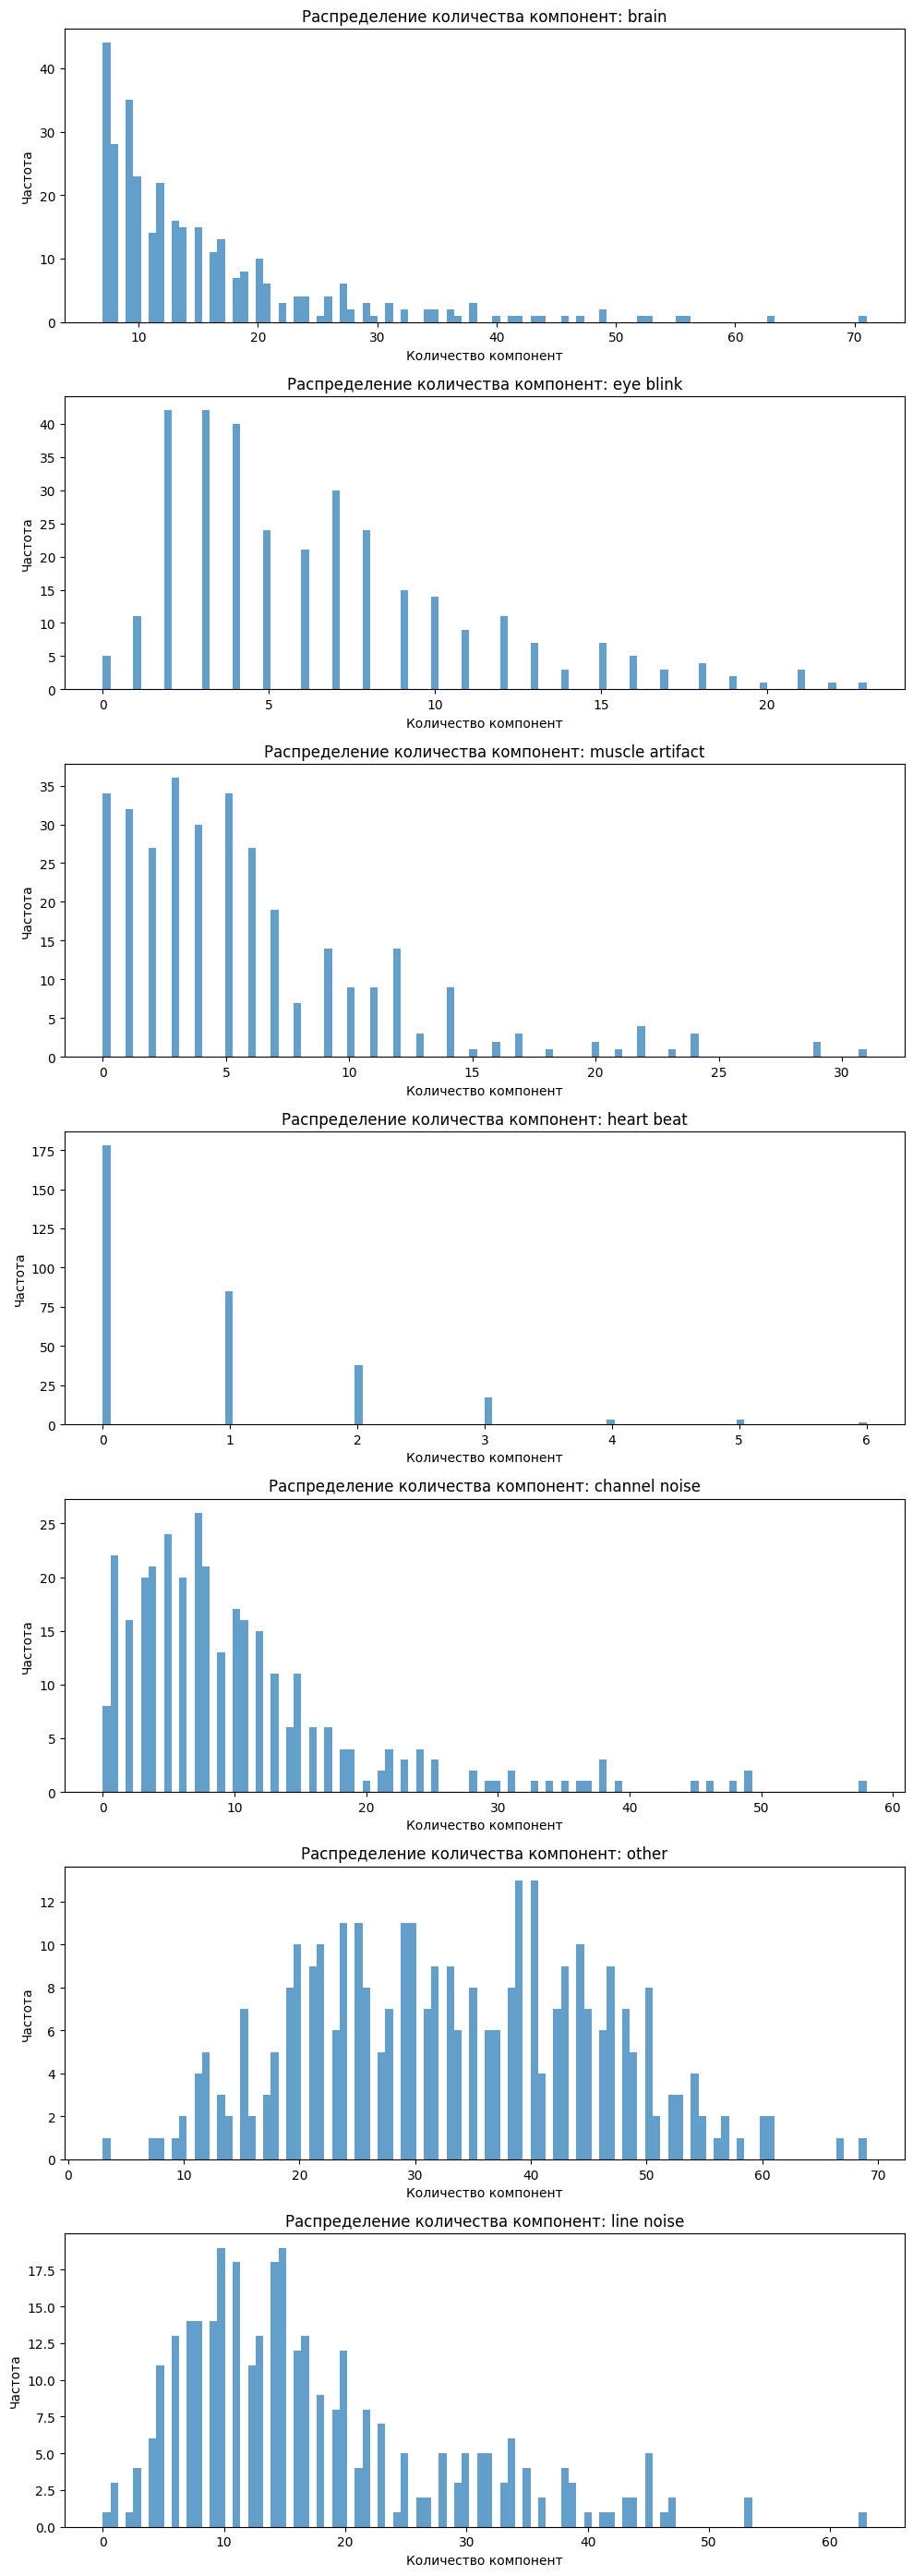


  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/1146 [16:47<?, ?it/s]


К анализу было допущено 95 файлов


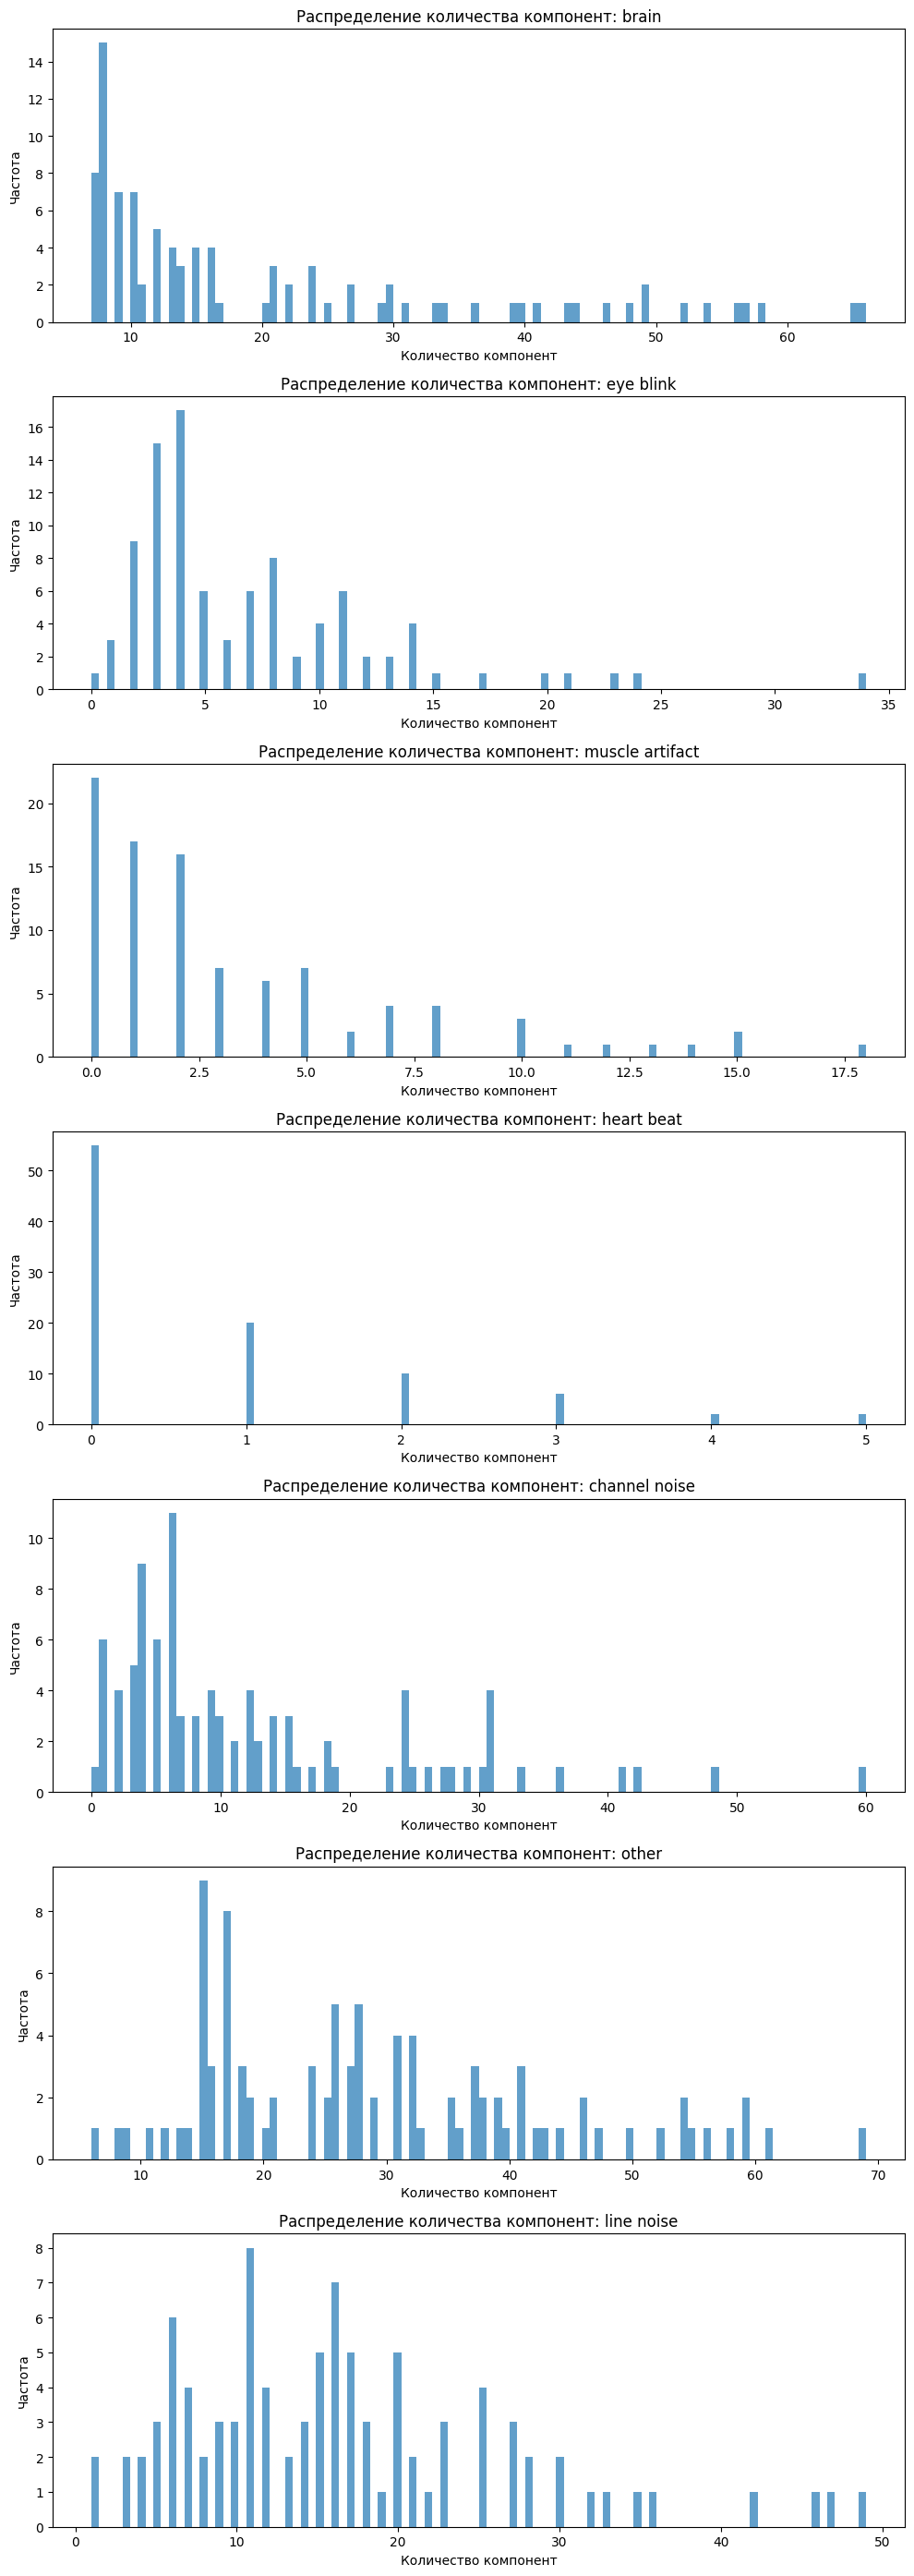

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

К анализу было допущено 98 файлов


  0%|          | 0/242 [06:23<?, ?it/s]


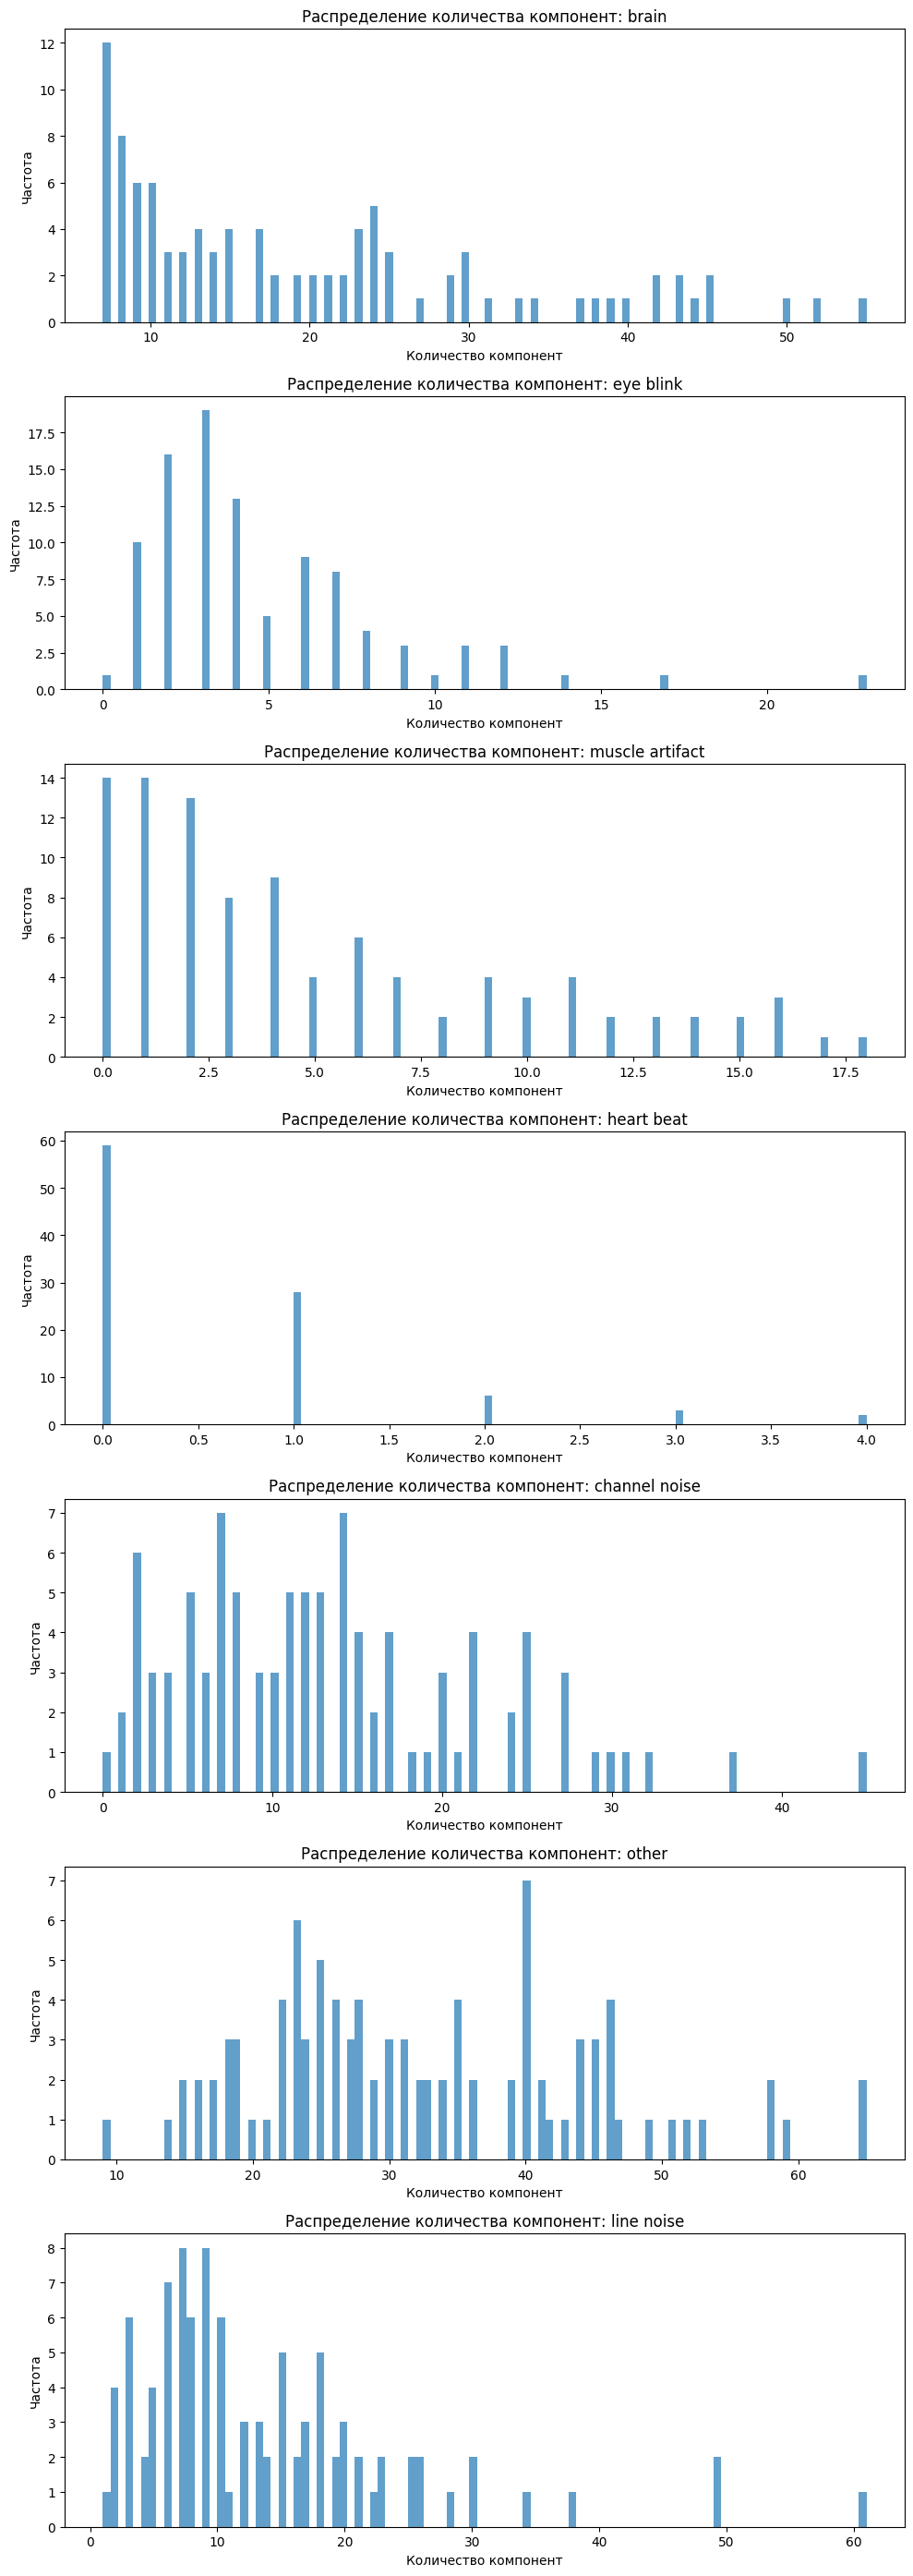

Size of Train Dataset: 24908
Size of Valid Dataset: 7210
Size of Test Dataset: 7475
================TRAIN===================


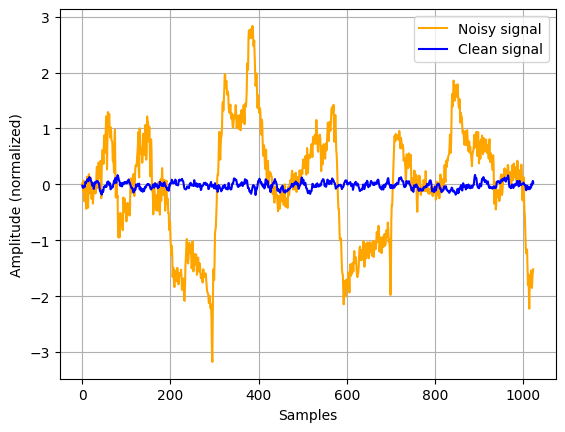

================VALID===================


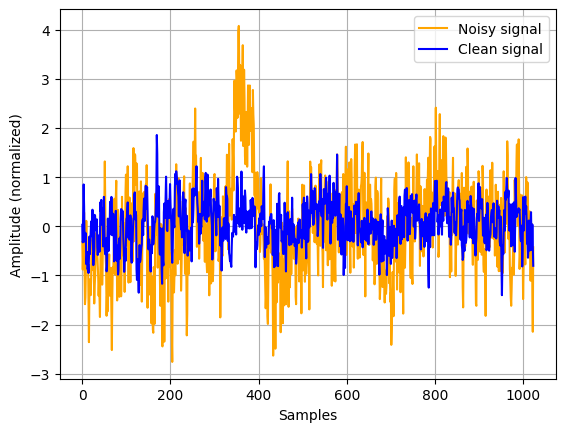

================TEST===================


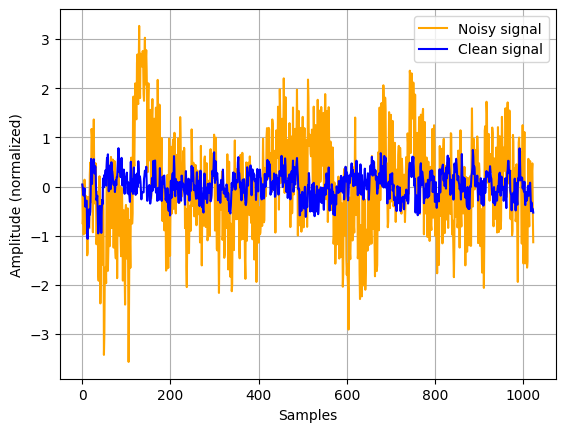

In [2]:
subject_files = {}
for sol, icl in zip(sol_files, iclabel_files):
    # Извлекаем sub-XXX из пути
    subject = Path(sol).parent.name.split('_')[0]  # Например, 'sub-001'
    if subject not in subject_files:
        subject_files[subject] = {'sol': [], 'icl': []}
    subject_files[subject]['sol'].append(sol)
    subject_files[subject]['icl'].append(icl)

subjects = list(subject_files.keys())
print(f"Total subjects: {len(subjects)}")
print(f"First participants: {subjects[:5]}")

train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15
random_seed = 42

train_subjects, temp_subjects = train_test_split(
    subjects, train_size=train_ratio, random_state=random_seed
)
valid_subjects, test_subjects = train_test_split(
    temp_subjects, train_size=valid_ratio/(valid_ratio + test_ratio), random_state=random_seed
)

train_sol_files = []
train_iclabel_files = []
valid_sol_files = []
valid_iclabel_files = []
test_sol_files = []
test_iclabel_files = []

for subject in train_subjects:
    train_sol_files.extend(subject_files[subject]['sol'])
    train_iclabel_files.extend(subject_files[subject]['icl'])
for subject in valid_subjects:
    valid_sol_files.extend(subject_files[subject]['sol'])
    valid_iclabel_files.extend(subject_files[subject]['icl'])
for subject in test_subjects:
    test_sol_files.extend(subject_files[subject]['sol'])
    test_iclabel_files.extend(subject_files[subject]['icl'])

print(f"Train: {len(train_subjects)} subjects, {len(train_sol_files)} files")
print(f"Valid: {len(valid_subjects)} subjects, {len(valid_sol_files)} files")
print(f"Test: {len(test_subjects)} subjects, {len(test_sol_files)} files")

batch_size = 32
num_workers = 8

def pad_collate(batch):
    T     = batch[0][0].size(1)
    clean_list = []
    noisy_list = []
    for clean, noisy in batch:
        C_i = clean.size(0)
        pad = C_max - C_i
        if pad > 0:
            # pad = (pad_T_left, pad_T_right, pad_C_left, pad_C_right)
            clean  = F.pad(clean,  (0,0, 0,pad))
            noisy  = F.pad(noisy,  (0,0, 0,pad))
        clean_list.append(clean)
        noisy_list.append(noisy)
    
    clean_batch = torch.stack(clean_list, dim=0)  # (B, C_max, T)
    noisy_batch = torch.stack(noisy_list, dim=0)  # (B, C_max, T)
    return clean_batch, noisy_batch

def check_dataset(dataset, ch=0, idx=32):
    clean, noisy = dataset[idx]
    plt.figure()
    plt.plot(noisy[ch].cpu(), label='Noisy signal', color='orange')
    plt.plot(clean[ch].cpu(), label='Clean signal', color='b')
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (normalized)")
    plt.legend()
    plt.grid(True)
    plt.show()

n_jobs = 25 #os.cpu_count()
segment_length = 1024
brain_threshold = 0.8
device_dataset = 'cpu'
target_sfreq=256
min_brain_components=6
max_other_componnets=80
print(f"Available CPU cores: {n_jobs}")


train_dataset = EEGArtifactDataset(train_sol_files, train_iclabel_files, segment_length=segment_length, brain_threshold=brain_threshold, 
                             n_jobs=n_jobs, device=device_dataset, target_sfreq=target_sfreq, 
                             min_brain_components=min_brain_components, max_other_componnets=max_other_componnets)
valid_dataset = EEGArtifactDataset(valid_sol_files, valid_iclabel_files, segment_length=segment_length, brain_threshold=brain_threshold, 
                             n_jobs=n_jobs, device=device_dataset, target_sfreq=target_sfreq, 
                             min_brain_components=min_brain_components, max_other_componnets=max_other_componnets)
test_dataset = EEGArtifactDataset(test_sol_files, test_iclabel_files, segment_length=segment_length, brain_threshold=brain_threshold, 
                             n_jobs=n_jobs, device=device_dataset, target_sfreq=target_sfreq, 
                             min_brain_components=min_brain_components, max_other_componnets=max_other_componnets)

C_max = max(*[ica.get_components().shape[0] for ica in train_dataset.icas], 
            *[ica.get_components().shape[0] for ica in valid_dataset.icas],
            *[ica.get_components().shape[0] for ica in test_dataset.icas])

print(f"Size of Train Dataset: {len(train_dataset)}")
print(f"Size of Valid Dataset: {len(valid_dataset)}")
print(f"Size of Test Dataset: {len(test_dataset)}")


train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=pad_collate,
    drop_last=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=pad_collate,
    drop_last=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=pad_collate,
    drop_last=False
)


print(f"================TRAIN===================")
check_dataset(train_dataset, ch=0, idx=0)
print(f"================VALID===================")
check_dataset(valid_dataset, ch=0, idx=0)
print(f"================TEST===================")
check_dataset(test_dataset, ch=0, idx=0)
    

In [3]:
src_vocab = 30
tgt_vocab = 30
N = 2
d_model = 128
torch.backends.cudnn.benchmark = True
model = make_model(src_vocab=src_vocab, tgt_vocab=tgt_vocab, N=N, d_model=d_model)

checkpoint = torch.load("checkpoint.pth.tar", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['state_dict'])

/home/aysurkov/Vasya/tf_model.py:340: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(p)
/tmp/job-2691887/ipykernel_229288/289154878.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. 

<All keys matched successfully>

In [4]:
for embed in (model.src_embed, model.tgt_embed):
    exp = embed[0]            # это ваш ExpandConv
    exp.d_model = d_model     # чтобы было в локальном scope
    exp._n_chan = C_max
    exp.lut = nn.Conv1d(in_channels=C_max,
                        out_channels=d_model,
                        kernel_size=1,
                        bias=True)

    def expand_forward(self, x):
        # x: (B, C_i, T)
        C_i = x.size(1)
        # берём только первые C_i каналов из весов [d_model × C_max × 1]
        w = self.lut.weight[:, :C_i, :]
        b = self.lut.bias
        y = F.conv1d(x, w, bias=b, stride=self.lut.stride, padding=self.lut.padding)
        # → (B, d_model, T) → (B, T, d_model) и масштаб
        return y.permute(0, 2, 1) * math.sqrt(self.d_model)

    exp.forward = types.MethodType(expand_forward, exp)

model.generator._n_chan = C_max    # <–– и здесь
model.generator.proj = nn.Linear(in_features=d_model,
                                 out_features=C_max,
                                 bias=True)

def generator_forward(self, x):
    C_i = self._n_chan
    W = self.proj.weight[:C_i, :]
    b = self.proj.bias[:C_i]
    B, T, D = x.shape
    flat = x.reshape(-1, D)          # (B*T, d_model)
    out = flat @ W.t() + b           # (B*T, C_i)
    return out.view(B, T, C_i)

model.generator.forward = types.MethodType(generator_forward, model.generator)

def init_xavier(m):
    if isinstance(m, (nn.Conv1d, nn.Linear)) and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.src_embed[0].apply(init_xavier)
model.tgt_embed[0].apply(init_xavier)
model.generator.apply(init_xavier)

for p in model.parameters():
    p.requires_grad = False
for m in (model.src_embed[0].lut,
          model.tgt_embed[0].lut,
          model.generator.proj):
    for p in m.parameters():
        p.requires_grad = True


In [5]:
print("CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("CUDA mem:", torch.cuda.mem_get_info())

CUDA version: 12.4
Device: cuda
CUDA mem: (33755365376, 34079899648)


In [6]:
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/259 [03:24<?, ?it/s]


75413

In [ ]:
import importlib
import metrics
importlib.reload(metrics)

num_epochs = 10
model.to(device)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.01
)
criterion = nn.MSELoss()


for epoch in range(num_epochs):
    phases = {
        "train": train_dataloader,
        "valid": valid_dataloader
    }
    
    for mode, dataloader in phases.items():
        if mode == "train":
            model.train()
        else:
            model.eval()
        
        epoch_loss = 0
        snr_total = 0
        l1_total = 0
        l2_total = 0
        l1_freq_total = 0
        l2_freq_total = 0
        band_errors_total = {band: 0 for band in ["delta", "theta", "alpha", "beta", "gamma"]}
        
        for (target, noised) in tqdm(dataloader, total=len(dataloader)):

            noised = noised.to(device)
            target = target.to(device)
            src_mask = torch.ones((noised.size(0), 1, noised.size(2)), device=device)  # [batch, 1, 2000]
            #print(src_mask.size())
            tgt_mask = None
            
            if mode == "train":
                optimizer.zero_grad()
                output = model(noised, target, src_mask, tgt_mask).permute(0, 2, 1)
                #print(f"Output shape: {output.shape}, Target shape: {target.shape}")
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            else:
                with torch.no_grad():
                    output = model(noised, target, src_mask, tgt_mask).permute(0, 2, 1)
                    loss = criterion(output, target)
            
            current_loss = loss.item()
            epoch_loss += current_loss
            
            # Evaluate metrics
            with torch.no_grad():
                snr, band_errors, l1_time, l2_time, l1_freq, l2_freq = evaluate(target, output, target_sfreq)
                snr_total += snr
                l1_total += l1_time
                l2_total += l2_time
                l1_freq_total += l1_freq
                l2_freq_total += l2_freq
                for band_name in band_errors_total:
                    band_errors_total[band_name] += band_errors[band_name]
            
        num_batches = len(dataloader)
        # Compute averages
        avg_loss = epoch_loss / num_batches
        avg_snr = snr_total / num_batches
        avg_l1 = l1_total / num_batches
        avg_l2 = l2_total / num_batches
        avg_l1_freq = l1_freq_total / num_batches
        avg_l2_freq = l2_freq_total / num_batches
        avg_band_errors = {band: total / num_batches for band, total in band_errors_total.items()}
        
        # Print formatted metrics
        print_metrics(epoch, mode, avg_loss, avg_snr, avg_band_errors, avg_l1, avg_l2, avg_l1_freq, avg_l2_freq)  
    

100%|██████████| 778/778 [07:00<00:00,  1.85it/s]



Epoch 0 - Train Metrics:
+------------------+-----------+
| Metric           |     Value |
+==================+===========+
| Loss             |  0.029763 |
+------------------+-----------+
| SNR (dB)         | 11.87     |
+------------------+-----------+
| L1 Time          |  0.121839 |
+------------------+-----------+
| L2 Time          |  0.029763 |
+------------------+-----------+
| L1 Freq          |  2.87426  |
+------------------+-----------+
| L2 Freq          | 18.1603   |
+------------------+-----------+
| delta Error (dB) |  0.97     |
+------------------+-----------+
| theta Error (dB) |  0.98     |
+------------------+-----------+
| alpha Error (dB) |  0.98     |
+------------------+-----------+
| beta Error (dB)  |  0.99     |
+------------------+-----------+
| gamma Error (dB) |  1        |
+------------------+-----------+


100%|██████████| 226/226 [01:21<00:00,  2.78it/s]



Epoch 0 - Valid Metrics:
+------------------+-----------+
| Metric           |     Value |
+==================+===========+
| Loss             |  0.01314  |
+------------------+-----------+
| SNR (dB)         | 15.26     |
+------------------+-----------+
| L1 Time          |  0.077263 |
+------------------+-----------+
| L2 Time          |  0.01314  |
+------------------+-----------+
| L1 Freq          |  1.39747  |
+------------------+-----------+
| L2 Freq          | 10.3552   |
+------------------+-----------+
| delta Error (dB) |  0.97     |
+------------------+-----------+
| theta Error (dB) |  0.98     |
+------------------+-----------+
| alpha Error (dB) |  0.98     |
+------------------+-----------+
| beta Error (dB)  |  0.97     |
+------------------+-----------+
| gamma Error (dB) |  0.95     |
+------------------+-----------+


 81%|████████  | 632/778 [05:35<01:11,  2.03it/s]

In [ ]:

def plot_signals(input_tensor, pred_tensor, target_tensor, sfreq=256, n_signals= 1):
    inputs  = input_tensor[:n_signals].cpu().numpy()
    preds   = pred_tensor[:n_signals].cpu().detach().numpy()
    targets = target_tensor[:n_signals].cpu().numpy()
    times = np.arange(inputs.shape[1]) / sfreq  # шкала времени в секундах

    titles = ["Noised Input", "Model Prediction", "Ground Truth"]
    datas = [inputs, preds, targets]
    for i in range(n_signals):
        plt.figure(figsize=(12, 6))
        for idx, data, title in zip(range(1, 4), datas, titles):
            plt.subplot(3, 1, idx)
            plt.plot(times, data[i])
            plt.title(f"Signal {i+1} — " + title)
            plt.ylabel("Amplitude")
        plt.xlabel("Time (s)")
        plt.tight_layout()
        plt.show()


data_idx = 21
chan = 0
model.eval()
with torch.no_grad():
    for idx, (target, noised) in enumerate(test_dataloader):
        if idx == data_idx:
            noised = noised.to(device)          # [batch, channels, time]
            target = target.to(device)
            src_mask = torch.ones((noised.size(0), 1, noised.size(2)), device=device)
            # Prediction
            output = model(noised, target, src_mask, None).permute(0, 2, 1)  # [batch, time, channels]
            # Для простоты переводим в [batch, time]
            input_sig  = noised[:, chan, :]
            pred_sig   = output[:, chan, :]   
            target_sig = target[:, chan, :]     
            
            plot_signals(input_sig, pred_sig, target_sig, sfreq=256, n_signals=2)
            break
            

In [ ]:

checkpoint = {
    'epoch': epoch,                              # текущая эпоха
    'model_state_dict': model.state_dict(),      # веса модели
    'optimizer_state_dict': optimizer.state_dict(),  # состояние оптимизатора
    'loss': loss.item(),                          # текущая потеря (для истории)
}

torch.save(checkpoint, 'my_checkpoint.pth')
